# expression_combined

In this notebook, we use a combination of features from the `ddg_monomer` feature set (13 features), the RosettaDesign data set (47 features), and the FoldX data set (12 features) to predict soluble expression (0=no, 1=yes) for 128 samples. Four classifiers are tried: naive Bayes, logistic regression, SVM, and random forest 

In [74]:
%matplotlib inline 
import matplotlib.pyplot as plt 

import pandas 
from pandas.tools.plotting import scatter_matrix

from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectKBest

In [75]:
# df1 = pandas.read_csv( '../rosetta_runs/reckless_ddg_monomer/ddg_feature_set.csv', index_col=0 ) 
# df2 = pandas.read_csv( 'feature_sets/expression.csv', index_col=0 ) 
# df3 = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 

# feature_set =  df1.join( df2, rsuffix='_enzyme_design' ).join( df3, rsuffix='_foldx' )
# feature_set.drop( [ 'expression', 'expression_foldx' ], axis=1, inplace=True ) 
# print feature_set.columns

# experimental = pandas.read_csv( '../data_sets/experimental/thermo_paper_data_set.csv', index_col=0 ) 
# express = experimental[ [ 'expression' ] ]

# df = express.join( feature_set ).dropna()
# print df.sample( 5 )
df = pandas.read_csv( 'feature_sets/expression_combined.csv', index_col=0 )

In [76]:
def plot_evaluation_curves( y_true, y_conf ):
    
    plt.figure()
    
    plt.subplot( 1, 2, 1 ) 
    
    # ROC curve 
    tpr, fpr, __ = roc_curve( y_true, y_prob ) 
    my_auc = roc_auc_score( y_true, y_prob ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.xlabel( 'True positive rate' )
    plt.ylabel( 'False positive rate' )
    plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
    plt.show()

    plt.subplot( 1, 2, 1 ) 
    
    # Precision-recall curve 
    precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
    my_auc = average_precision_score( y_true, y_prob ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( recall, precision ) 
    plt.xlabel( 'Recall' )
    plt.ylabel( 'Precision' )
    plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
    plt.show()

In [77]:
# # %matplotlib inline 
# # import matplotlib.pyplot as plt 

# plt.figure( figsize=( 14, 14 ) ) 

# for i, feature in enumerate( df.columns ):
#     plt.subplot( 4, 4, i + 1 ) 
#     plt.scatter( df.expression, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
#     plt.title( feature ) 
#     plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

# plt.show()

In [78]:
#scatter_matrix(df, alpha=0.2, figsize=(14, 14) ) #, diagonal='kde')

In [79]:
# sequence-based view of features 
#df.plot(subplots=True, style='.', figsize=(14,14))

In [87]:
# scale features and separate into predictors

scl = preprocessing.MinMaxScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1].as_matrix().ravel()

print X.shape
print y.shape

(126, 76)
(126,)


In [88]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

43 samples of class 0
83 samples of class 1


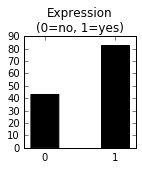

In [89]:
plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [90]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

In [91]:
### Helper function to plot evaluation curves and calculate statistical measures for us 

def plot_evaluation_curves( y_true, y_conf ):
    
    plt.figure()
    
    plt.subplot( 1, 2, 1 ) 
    
    # ROC curve 
    tpr, fpr, __ = roc_curve( y_true, y_prob ) 
    my_auc = roc_auc_score( y_true, y_prob ) 
    plt.plot( tpr, fpr ) 
    plt.xlabel( 'True positive rate' )
    plt.ylabel( 'False positive rate' )
    plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
    
    plt.subplot( 1, 2, 2 ) 
    
    # Precision-recall curve 
    precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
    my_auc = average_precision_score( y_true, y_prob ) 
    plt.plot( recall, precision ) 
    plt.xlabel( 'Recall' )
    plt.ylabel( 'Precision' )
    plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 

In [92]:
### Begin the classifiers

Best parameters found on training set
{}
Grid scores on training set
0.730 (±0.233) for {}
Detailed classification report
             precision    recall  f1-score   support

          0       0.42      0.20      0.27        25
          1       0.61      0.82      0.70        38

avg / total       0.53      0.57      0.53        63



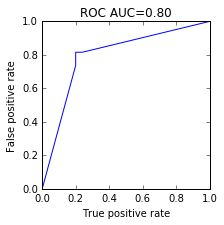

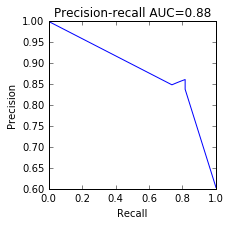

In [93]:
# naive Bayes 

from sklearn.naive_bayes import GaussianNB

pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

param_grid = [
    { 
    },
]

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

y_true, y_pred = y_test, clf.predict(X_test)

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[1:], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [94]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

Best parameters found on training set
{'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 6, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': None}
Grid scores on training set
0.778 (±0.358) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 1}
0.778 (±0.292) for {'rf__n_estimators': 50, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 1}
0.762 (±0.352) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 2}
0.810 (±0.247) for {'rf__n_estimators': 50, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 2}
0.746 (±0.309) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 'sqrt'}
0.7

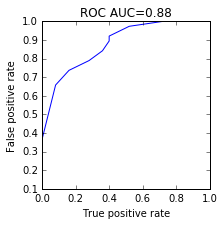

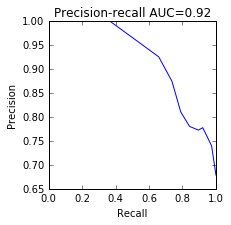

,importance
feature,
hbond_sc_enzyme_design,0.163446
tot_nlsurfaceE_pm_enzyme_design,0.102752
tot_total_pos_charges_enzyme_design,0.087506
Backbone Hbond_foldx,0.068666
SR_3_hbond_sc_enzyme_design,0.066880
tot_total_charge_enzyme_design,0.062805
SR_4_pstat_pm_enzyme_design,0.059787
SR_1_pstat_pm_enzyme_design,0.051614
SR_1_nlpstat_pm_enzyme_design,0.038314


In [95]:
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

y_true, y_pred = y_test, clf.predict(X_test)

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
print classification_report( y_true, y_pred )

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[1:], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

# Tuning hyper-parameters for precision


/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [22] are constant.
  UserWarning)
/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [22 29 57 67 72] are constant.
  UserWarning)


Best parameters set found on development set:
{'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}

Grid scores on development set:

0.274 (+/-0.461) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.793 (+/-0.369) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.274 (+/-0.461) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.0001}
0.793 (+/-0.369) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.0001}
0.179 (+/-0.439) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.773 (+/-0.386) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.179 (+/-0.439) for {'kbest__k': 2

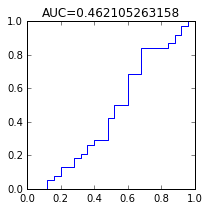

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}

Grid scores on development set:

0.476 (+/-0.444) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.730 (+/-0.396) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001}
0.476 (+/-0.444) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.0001}
0.730 (+/-0.396) for {'kbest__k': 2, 'svm__C': 0.3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.0001}
0.381 (+/-0.399) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'rbf', 'svm__gamma': 0.001}
0.730 (+/-0.416) for {'kbest__k': 2, 'svm__C': 3, 'svm__class_weight': 'balanced', 'svm__kernel': 'linear', 'svm__gamma': 0.001

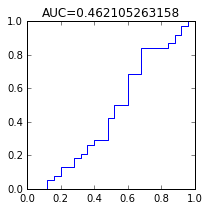

In [96]:
# SVM with KBest 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'kbest__k': [ 2, 5, 10, 20, 40 ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'kbest', SelectKBest() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

# Tuning hyper-parameters for precision
Best parameters set found on development set:
{'svm__C': 30, 'pca__n_components': 10, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}

Grid scores on development set:

0.083 (+/-0.049) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.672 (+/-0.292) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.083 (+/-0.049) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.672 (+/-0.292) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.274 (+/-0.461) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__

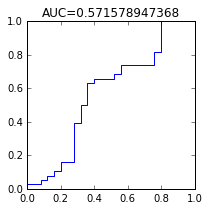

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'svm__C': 30, 'pca__n_components': 5, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Grid scores on development set:

0.286 (+/-0.093) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.635 (+/-0.249) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.286 (+/-0.093) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.635 (+/-0.249) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.476 (+/-0.444) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten'

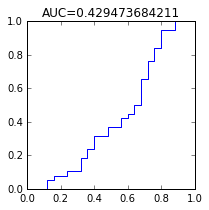

In [97]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

Best parameters found on training set
{'logit__class_weight': 'balanced'}
Grid scores on training set
0.730 (±0.442) for {'logit__class_weight': 'balanced'}
Detailed classification report
             precision    recall  f1-score   support

          0       0.50      0.28      0.36        25
          1       0.63      0.82      0.71        38

avg / total       0.58      0.60      0.57        63



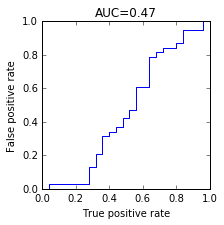

MCC= 0.112724296038


In [98]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced' ],
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

#y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
#y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label
y_prob = clf.decision_function( X_test ) 

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

print 'MCC=', matthews_corrcoef( y_true, y_pred ) 

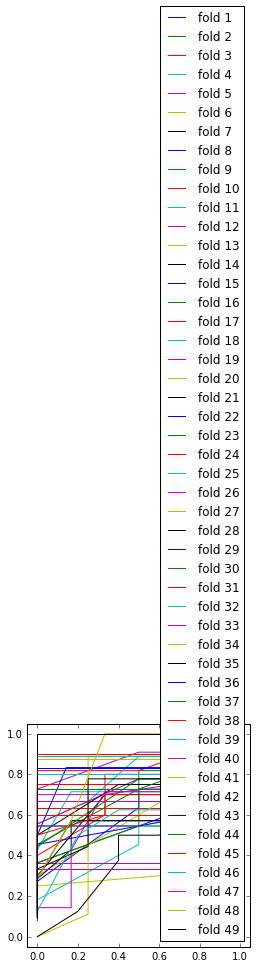

In [108]:
# Split the dataset in two equal parts

from sklearn.ensemble import RandomForestClassifier

my_importances = []

plt.figure( figsize=( 4,4 ) ) 

for my_iter in range( 1, 50 ):

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1)
    forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight='balanced_subsample', max_features=2)
    forest.fit(X_train, y_train)

    preds = forest.predict( X_test ) 
    probs = [ i[j] for i, j in zip( forest.predict_proba( X_test ), y_test ) ] 

    tpr, fpr, __ = roc_curve( preds, probs ) 

    plt.plot( tpr, fpr, label='fold {}'.format( my_iter ) ) 
    plt.xlim( -0.05, 1.05 )
    plt.ylim( -0.05, 1.05 )
    
    my_importances.append( forest.feature_importances_ )
    
plt.legend( loc='lower right' ) 

In [109]:
import pandas 

my_df = pandas.DataFrame( my_importances, columns=df.columns[1:] )
means = my_df.mean()
st = my_df.std()

print 'Average weight over all iterations' 

my_sorted = means.sort_values(ascending=False)
my_sorted

Average weight over all iterations


tot_nlsurfaceE_pm_enzyme_design        0.034907
SR_1_pstat_pm_enzyme_design            0.033126
tot_total_neg_charges_enzyme_design    0.024814
SR_2_nlpstat_pm_enzyme_design          0.021821
SR_4_burunsat_pm_enzyme_design         0.020987
SR_5_hbond_pm_enzyme_design            0.020744
tot_hbond_pm_enzyme_design             0.020517
Backbone Hbond_foldx                   0.020306
pro_close_ddg                          0.019980
fa_elec_ddg                            0.019281
tot_total_pos_charges_enzyme_design    0.018926
fa_sol_ddg                             0.018246
SR_3_nlpstat_pm_enzyme_design          0.018183
tot_nlpstat_pm_enzyme_design           0.017830
SR_4_hbond_pm_enzyme_design            0.017801
SR_4_fa_rep_enzyme_design              0.017765
fa_rep_enzyme_design                   0.017316
fa_intra_rep_ddg                       0.016830
SR_1_fa_rep_enzyme_design              0.016231
SR_2_burunsat_pm_enzyme_design         0.016144
rama_ddg                               0

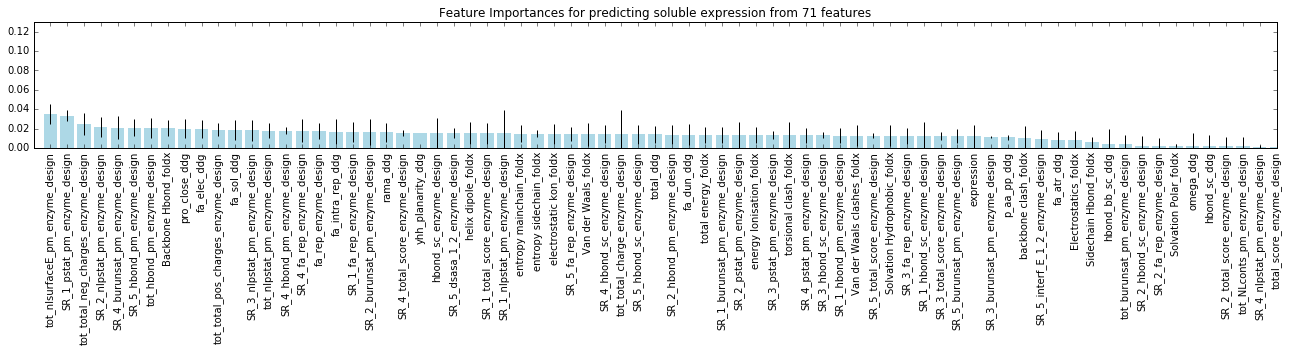

In [110]:
plt.figure( figsize=( 18, 5 ) ) 
plt.title('Feature Importances for predicting soluble expression from 71 features')

plt.bar( range( len( my_sorted ) ), my_sorted, color='lightblue',
         align='center', lw=0, ecolor='k', yerr=st, error_kw=dict(capsize=0) )
plt.xticks( range( len( my_sorted ) ), my_sorted.index, rotation=90 )            

plt.ylim( 0, .13 )
plt.xlim( -1, 73 ) 
plt.tight_layout()
plt.show()

